# Treble in the Sheets Semantic Segmentaion
In this part, you will design and implement your Convolutional Neural Networks to perform semantic segmentation on the Microsoft Research in Cambridge (MSRC) image understanding v2 dataset.

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) David FOUHEY, #12345678

## Setup
First, we will install some required packages for this notebook and download the MSRC-v2 Image dataset. 


In [126]:
# install required packages and download the dataset
# Run the command in the terminal if it failed on local Jupyter Notebook, remove "!" before each line
!pip install colormap easydev pypng torchsummary
!pip install mingus
!pip install midiutil

     |████████████████████████████████| 1.0 MB 6.5 MB/s eta 0:00:01
  Created wheel for midiutil: filename=MIDIUtil-1.2.1-py3-none-any.whl size=54565 sha256=42a86c66310b3a583cb277e6ca2fe4371d3feb100703377f441e9aa781276ca5
  Stored in directory: /Users/drewscheffer/Library/Caches/pip/wheels/55/14/ba/8d51301658e4a79bbcc3a1a1fd3ea32abc72798fc9e92b56fa
Successfully built midiutil


In [31]:
import os
import time
import json
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import png
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from PIL import Image
import torchvision
from colormap.colors import Color, hex2rgb
from sklearn.metrics import average_precision_score as ap_score
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
from tqdm import tqdm

In [3]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = 'cuda'
else:
    print("Using the CPU. Overall speed will be slowed down")
    device = 'cpu'

Using the CPU. Overall speed will be slowed down


## Dataset
We will create a custom Dataset function for the MSRC-v2 dataset. You don't have to change anything here.

In [4]:
N_CLASS = 13

class DeepScoresDataset(Dataset):
    def __init__(self, split, 
                 split_path="ds2_dense/split.json",
                 one_hot=False):
        super().__init__()
        self.one_hot = one_hot
        img_folder = 'ds2_dense/Images'
        mask_folder = 'ds2_dense/GroundTruth'
        GTQ_folder = 'ds2_dense/GT_Quantize'
        
        self.dataset = json.load(open(split_path, 'r'))[split]
        
        self.group2label_idx = {'void': 0, 'lineNote': 1, 'quarterRest': 2, 'clef': 3, 'middleNote': 4, 'stem': 5, 'bars': 6, 'middleWholes': 7, 'lineWholes': 8, 'middleHalves': 9, 'lineHalves': 10, 'sharps': 11, 'flats': 12}
        
        self.img_list = [data[0] for data in self.dataset] #These are file names
        self.mask_list = [data[1] for data in self.dataset] #These are file names
        GTQ_list = [data[2] for data in self.dataset] #These are file names
        self.imgs = [np.array(Image.open(os.path.join(img_folder, img))) 
                     for img in self.img_list]
        self.masks = [np.array(Image.open(os.path.join(mask_folder, mask))) 
                      for mask in self.mask_list]
        self.q_masks = [np.load(os.path.join(GTQ_folder, gtq))
                        for gtq in GTQ_list]
            
        self.transform = transforms.Compose([
            transforms.Resize((848, 600))
        ])

    @staticmethod
    def rgb2str(rgb): return f"{rgb[0]},{rgb[1]},{rgb[2]}"

    @staticmethod
    def str2rgb(string): return [int(v) for v in string.split(',')]
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img = torch.FloatTensor(self.imgs[idx]).permute(2, 0, 1)
        qmask = torch.LongTensor(self.q_masks[idx])[None, :, :]
        qmask = qmask.squeeze()
        if self.one_hot:
            H, W = qmask.shape
            qmask = torch.nn.functional.one_hot(qmask.reshape(-1), len(self.group2label_idx)).reshape(H, W, -1)
            qmask = qmask.permute(2, 0, 1)
            assert torch.max(qmask) == 1
        
#         # Resize
#         resize = transforms.Resize(size=(img.shape[0]/2, img.shape[1]/2))
#         img = resize(img)
#         qmask = resize(mask)
        
        i, j, h, w = transforms.RandomCrop.get_params(
                img, output_size=(256, 512))
        img = transforms.functional.crop(img, i, j, h, w)
        qmask = transforms.functional.crop(qmask, i, j, h, w)
        
        
        return img, qmask

## Model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.n_class = N_CLASS
        ########################################################################
        # TODO: Implement a sematic segmentation model                         #
        ########################################################################
        self.sampling_factor = 2
        
        self.relu = nn.ReLU()
        
        #First Block (Downsampling 1)
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1, stride=1)
        self.maxpool1 = nn.MaxPool2d(self.sampling_factor)
        
        #Second Block (Downsampling 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1, stride=1)
        self.maxpool2 = nn.MaxPool2d(self.sampling_factor)
        
        #Center Convolution
        self.convMiddle = nn.Conv2d(64, 64, 3, padding=1, stride=1)
        
        #Third block (Upsampling 1)
        self.upsample1 = nn.Upsample(scale_factor=self.sampling_factor, mode='nearest')
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1, stride=1)
        self.conv6 = nn.Conv2d(64, 32, 3, padding=1, stride=1)
        
        #Fourth block (upsampling 2)
        self.upsample2 = nn.Upsample(scale_factor=self.sampling_factor, mode='nearest')
        self.conv7 = nn.Conv2d(32, 32, 3, padding=1, stride=1)
        self.conv8 = nn.Conv2d(32, 32, 3, padding=1, stride=1)
        
        self.conv9 = nn.Conv2d(32, self.n_class, 3, padding=1, stride=1)
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        
        x = self.convMiddle(x)
        x = self.relu(x)
        
        x = self.upsample1(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        
        x = self.upsample2(x)
        x = self.conv7(x)
        x = self.relu(x)
        x = self.conv8(x)
        x = self.relu(x)
        
        x = self.conv9(x)
        
        
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return x

Ininitialize your model and look at the structure of your model, [torchsummary](https://github.com/sksq96/pytorch-summary) is a useful library to look at the computation graph of your model.

In [6]:
name = 'starter_net'
net = Net().to(device)
# visualizing the model
print('Your network:')
summary(net, (3,512,256), device=device)

Your network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 256]             896
              ReLU-2         [-1, 32, 512, 256]               0
            Conv2d-3         [-1, 32, 512, 256]           9,248
              ReLU-4         [-1, 32, 512, 256]               0
         MaxPool2d-5         [-1, 32, 256, 128]               0
            Conv2d-6         [-1, 64, 256, 128]          18,496
              ReLU-7         [-1, 64, 256, 128]               0
            Conv2d-8         [-1, 64, 256, 128]          36,928
              ReLU-9         [-1, 64, 256, 128]               0
        MaxPool2d-10          [-1, 64, 128, 64]               0
           Conv2d-11          [-1, 64, 128, 64]          36,928
             ReLU-12          [-1, 64, 128, 64]               0
         Upsample-13         [-1, 64, 256, 128]               0
           Conv2d-14     

Once you have completed the model implementation in the cell above, run the cell below to load helper functions and train the model.

# Training

In [7]:
def save_label(label, path, ):
    '''
    Function for ploting labels.
    '''
    colormap = [
        '#0080FF',
        '#000000',
        '#80FF80',
        '#FF8000', # CLEF
        '#FFFFFF',
        '#348201',
        '#e63492',
        '#b95b18',
        '#32e2aa', #Middle Halves
        '#262a5a', #Line Halves
        '#f0ae3b',
        '#a49540', #sharps
        '#f8fb25' #Flats
        
    ]
    assert(np.max(label)<len(colormap))
    colors = [hex2rgb(color, normalise=False) for color in colormap]
    w = png.Writer(label.shape[1], label.shape[0], palette=colors, bitdepth=4)
    with open(path, 'wb') as f:
        w.write(f, label)

def train(trainloader, net, criterion, optimizer, device, epoch):
    '''
    Function for training.
    '''
    start = time.time()
    running_loss = 0.0
    cnt = 0
    net = net.train()
    for images, labels in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        cnt += 1
    end = time.time()
    running_loss /= cnt
    print('\n [epoch %d] loss: %.3f elapsed time %.3f' %
        (epoch, running_loss, end-start))
    return running_loss

def test(testloader, net, criterion, device):
    '''
    Function for testing.
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)
            loss = criterion(output, labels)
            losses += loss.item()
            cnt += 1
    print('\n',losses / cnt)
    return (losses/cnt)


def cal_AP(testloader, net, criterion, device):
    '''
    Calculate Average Precision
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        preds = [[] for _ in range(N_CLASS)]
        heatmaps = [[] for _ in range(N_CLASS)]
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images).cpu().numpy()
            for c in range(N_CLASS):
                preds[c].append(output[:, c].reshape(-1))
                heatmaps[c].append(labels[:, c].cpu().numpy().reshape(-1))

        aps = []
        for c in range(N_CLASS):
            preds[c] = np.concatenate(preds[c])
            heatmaps[c] = np.concatenate(heatmaps[c])
            if heatmaps[c].max() == 0:
                ap = float('nan')
            else:
                ap = ap_score(heatmaps[c], preds[c])
                aps.append(ap)
            print("AP = {}".format(ap))
        print("Average Precision (all classes) = {}".format(np.mean(aps)))
    return None


def get_result(testloader, net, device, folder='output_train'):
    result = []
    cnt = 1
    os.makedirs(folder, exist_ok=True)
    with torch.no_grad():
        net = net.eval()
        cnt = 0
        for images, labels in tqdm(testloader):
            images = images.to(device)
            print(images.shape)
            labels = labels.to(device)
            output = net(images)[0].cpu().numpy()
            c, h, w = output.shape
            assert(c == N_CLASS)
            y = np.argmax(output, 0).astype('uint8')
            gt = labels.cpu().data.numpy().squeeze(0).astype('uint8')
            save_label(y, './{}/y{}.png'.format(folder, cnt))
            save_label(gt, './{}/gt{}.png'.format(folder, cnt))
            plt.imsave('./{}/x{}.png'.format(folder, cnt),
                     images[0].cpu().data.numpy().astype(np.uint8).transpose(1,2,0))
            cnt += 1

def plot_hist(trn_hist, val_hist):
    x = np.arange(len(trn_hist))
    plt.figure(figsize=(12, 8))
    plt.plot(x, trn_hist)
    plt.plot(x, val_hist)
    plt.legend(['Training', 'Validation'])
    plt.xticks(x)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('part3_training_hist.png', dpi=300)
    plt.show()

##### Experiment with with different optimizers, parameters (such as learning rate) and number of epochs. We expect you to achieve **0.65 all classes AP** on the test set. We also encourage to try to get a higher AP by improving your model design.

On normal Intel core CPU configuration, a valid model design that meets this requirement takes no longer than **10 minutes** to train. The same model take no more than **5 mintues** to finish the code below on Colab. You may use this as a reference when designing your own model. A network that is too deep/too large is not encouraged considering the size of the dataset.

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [ ]:
%%time
# Set up the random seed for reproducibility, you should not modify the seed used here
torch.manual_seed(442)
random.seed(442)
np.random.seed(442)

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
#criterion = DiceLoss()

# Define the dataset and dataloder
print("HEre")
train_data = DeepScoresDataset("train")
print("HEre")
val_data = DeepScoresDataset("validation")
print("HEre")
test_data = DeepScoresDataset("test")
print("HEre")

train_loader = DataLoader(train_data, batch_size=2)
val_loader = DataLoader(val_data, batch_size=2)

test_loader = DataLoader(test_data, batch_size=1)

# ap_loader for calculating Average Precision
ap_data = DeepScoresDataset("test", one_hot=True)
ap_loader = DataLoader(ap_data, batch_size=1)

learning_rate = 0.001
weight_decay = 0#1e-5
num_epoch = 50  # TODO: Choose an appropriate number of training epochs
optimizer = optim.Adam(net.parameters(), lr=learning_rate,
                       weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

print('\nStart training')
trn_hist = []
val_hist = []
net.train()
for epoch in range(num_epoch): #TODO: Change the number of epochs
    print('-----------------Epoch = %d-----------------' % (epoch+1))
    trn_loss = train(train_loader, net, criterion, optimizer, device, epoch+1)
    print('Validation loss: ')
    val_loss = test(val_loader, net, criterion, device)
    trn_hist.append(trn_loss)
    val_hist.append(val_loss)

net.eval()
plot_hist(trn_hist, val_hist)

print('\nFinished Training, Testing on test set')
test(test_loader, net, criterion, device)
print('\nGenerating Unlabeled Result')

result = get_result(test_loader, net, device, folder='output_test')

os.makedirs('./models', exist_ok=True)
torch.save(net.state_dict(), './models/model_skiplink_{}.pth'.format(name))
print("Here")
cal_AP(ap_loader, net, criterion, device)

# Testing

image: 8


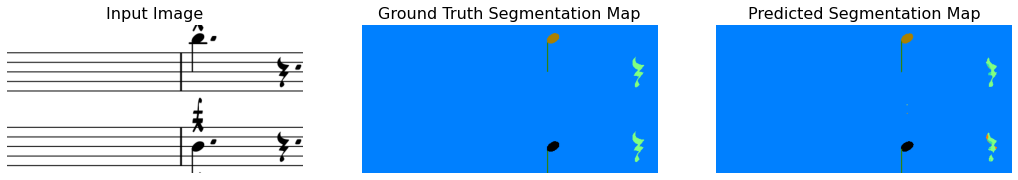

In [34]:
img_idx = 8

print(f'image: {img_idx}')
output_dir = 'output_test'

plt.subplot(1, 3, 1)
plt.imshow(Image.open(os.path.join(output_dir, 'x{}.png'.format(img_idx))))
plt.title('Input Image', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(Image.open(os.path.join(output_dir, 'gt{}.png'.format(img_idx))))
plt.title('Ground Truth Segmentation Map', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(Image.open(os.path.join(output_dir, 'y{}.png'.format(img_idx))))
plt.title('Predicted Segmentation Map', fontsize=16)
plt.axis('off')

plt.gcf().set_size_inches(18, 10)
plt.show()

# Full Page Combiner

(2772, 1960, 3)
0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
5 0
5 1
5 2
5 3
6 0
6 1
6 2
6 3
7 0
7 1
7 2
7 3
8 0
8 1
8 2
8 3
9 0
9 1
9 2
9 3
10 0
10 1
10 2
10 3
Finished Making All the Images!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


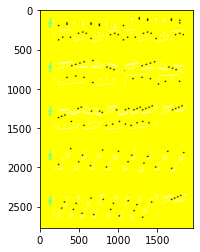

In [10]:
import math
import cv2

## Load the NET
net = Net().to(device)
net.load_state_dict(torch.load("./models/model_april_23.pth"))
net.eval()

# Get Image with some padding
img_name = 'test_orig.png'
img = np.array(Image.open(img_name))
#img = cv2.resize(img, dsize=(img.shape[1]*2, img.shape[0]*2))

#img = np.stack((img,)*3, axis=-1)
print(img.shape)
#img = np.array([img, img, img])
cv2.imwrite(os.path.join('output', img_name), img)
H, W, _ = img.shape

img_w_padding = array_created = np.full((H + 256, W+512, 3), 255, dtype = np.uint8)
img_w_padding[0:H, 0:W] = img
img = img_w_padding

segmented_img = np.zeros(img.shape)
img = torch.FloatTensor(img).permute(2, 0, 1)


##### Segment the image a bunch of times
for row in range(math.ceil(H/256)):
    for col in range(math.ceil(W/512)):
        print(row, col)
        i = row * 256
        j = col*512
        h = 256
        w = 512
        

        cropped_img = transforms.functional.crop(img, i, j, h, w)
        cropped_img = cropped_img.unsqueeze(0)

        folder = "output"

        os.makedirs(folder, exist_ok=True)
        with torch.no_grad():
            output = net(cropped_img)[0].cpu().numpy()
            c, h, w = output.shape
            assert(c == N_CLASS)
            y = np.argmax(output, 0).astype('uint8')
            save_label(y, './{}/{},{}.png'.format(folder, row, col))
print("Finished Making All the Images!")

##### Put the images back together
for row in range(math.ceil(H/256)):
    for col in range(math.ceil(W/512)):
        f_name = str(row) + "," + str(col) + ".png"
        segmented_segment = cv2.imread(os.path.join('output', f_name), cv2.IMREAD_COLOR)
        i = row * 256
        j = col*512
        segmented_img[i:i+256, j:j+512] = segmented_segment

segmented_img = segmented_img[0:H, 0:W]
cv2.imwrite('output/final.png', segmented_img)
plt.imshow(segmented_img)
plt.show()

# Note Identification

In [150]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

line_centers = []
#distBetweenNotes = 1

# type is if it is a gap note or line note
def find_note(row, type):
    minIndex = 0
    minDist = np.inf
    for i, x in enumerate(line_centers):
        dist = np.abs(row - x)
        if dist < minDist:
            minDist = dist
            minIndex = i
    
    # plus or minus
    pom = "+"
    if line_centers[minIndex] - row < 0:
        pom = "-"
    
    notesFromBase = chr(ord('a') + (round((line_centers[minIndex] - row) / distBetweenNotes) + 50) % 7)
    return minIndex, notesFromBase, pom, minDist

def verticalScan(filename):    	
    image = cv2.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    vertScanMat = np.sum(gray <= 70, axis=1) 
    bar = np.empty(gray.shape)
    bar.fill(255)
    for i in range(bar.shape[0]):
        if (vertScanMat[i] > gray.shape[1]/3):  
            bar[i,:] = 0
    rowNums = np.zeros(bar.shape[0])
    #print(bar.shape)
    lineCount = 0
    #file_name = open("sample.txt", "w+")
    lastdiff = 7 #Has to be atleast 10 pixels away
    line_centers = []
    for i, row in enumerate(bar):        
        if (row[0] == 0 and lastdiff < 0):
            #file_name.write(str(lineCount % 5 + 1) + "\n")
            rowNums[i] = lineCount % 5 + 1
            if ((lineCount % 5 + 1) == 3):
                line_centers.append(i)
            lineCount += 1
            lastdiff = 7
        else:
            #file_name.write("0" + "\n")
            rowNums[i] = 0
            lastdiff-= 1
    return bar, line_centers

def findFirstStaff(lines): #lines is just bar from previous function
    #keep going 20 pixels up, if there is black, need to go 20 pixels up and add 1
    #lines = cv2.bitwise_not(lines)
    distBetweenLines = lines.shape[0]
    lineSep = 0
    for row in lines:
        #print(row)
        if (row[0] == 0):
            if (lineSep < distBetweenLines and lineSep > 3):
                distBetweenLines = lineSep
            lineSep = 0
        else:
            lineSep += 1
    print(distBetweenLines)
    distBetweenNotes = math.ceil(distBetweenLines /2)
    #print("DistLines", distBetweenLines)
    return distBetweenNotes
    
bar, line_centers = verticalScan("test_orig.png")
distBetweenNotes = findFirstStaff(bar)
print(line_centers)


15
[164, 329, 724, 889, 1285, 1450, 1845, 2029, 2424, 2601]


# Putting Notes on the Image

In [151]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def get_width_height(rect, h, w):

    for i in range(0, 4, 1):
        if rect[i][0] < 0:
            rect[i][0] = 0;
        if rect[i][1] < 0:
            rect[i][1] = 0;
        if rect[i][0] > w -1:
            rect[i][0] = w -1
        if rect[i][1] > h -1:
            rect[i][1] = h -1


    furthest_top = rect[0][1]
    if (rect[1][1] < furthest_top):
        furthest_top = rect[1][1]

    furthest_bot = rect[2][1]
    if (rect[3][1] > furthest_bot):
        furthest_bot = rect[3][1]

    furthest_right = rect[1][0]
    if (rect[2][0] > furthest_right):
        furthest_right = rect[2][0]

    furthest_left = rect[0][0]
    if (rect[3][0] < furthest_left):
        furthest_left = rect[3][0]

    height = furthest_bot - furthest_top
    width = furthest_right - furthest_left


    return (int(furthest_left), int(furthest_top), int(width), int(height))

In [152]:
import imutils
frame = cv2.imread('output/final.png')
orig_image = cv2.imread('test_orig.png')
H, W = orig_image.shape[:2]
height, width = frame.shape[:2]

line_note_mask = cv2.inRange(frame, (0,0,0), (0, 0, 0))
gap_note_mask = cv2.inRange(frame, (255, 255, 255), (255, 255, 255))


filters = [("line_note", np.array([0, 0, 0]), np.array([0, 0, 0])), \
            ("gap_note", np.array([255, 255, 255]), np.array([255, 255, 255]))]

boxes = {}

for name, lower_bound, upper_bound in filters:
    mask = cv2.inRange(frame, lower_bound, upper_bound)
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    
    if len(cnts)>0:
        curr_boxes = []
        for (i, c) in enumerate(cnts):
            box = cv2.minAreaRect(c)
            box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
            box = np.array(box, dtype="int")
            cv2.drawContours(orig_image, [box], -1, (0, 255, 0), 2)
            
            rect = order_points(box)
            center = ((rect[0][1] + rect[1][1] + rect[2][1] + rect[3][1])/4, (rect[0][0] + rect[1][0] + rect[2][0] + rect[3][0])/4)
            colors = ((0, 0, 255), (240, 0, 159), (255, 0, 0), (255, 255, 0))
            
            # Get properly oriented bounding box
            # x, y, w, h = get_width_height(rect, height, width)
            
            x, y, w, h = get_width_height(rect, H, W)
            center = (x + int(w/2), y + int(h/2))
            curr_boxes.append(center)
            
            ##Place the note
            _, note, _, minDist = find_note(center[1], name)
            
            cv2.circle(orig_image, (int(center[0]), int(center[1])) , 5, (0, 255, 0), -1)
            
            for ((x, y), color) in zip(rect, colors):
                cv2.circle(orig_image, (int(x), int(y)), 5, color, -1)

            cv2.putText(orig_image, "{},{},{}".format(note, minDist, name[0:3]),
                (int(rect[0][0] - 15), int(rect[0][1] - 15)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 0, 255), 2)
            
        cv2.imwrite('output/annotted.png', orig_image)
        boxes[name] = curr_boxes
#print(boxes)

# Get Ordered Note Values

In [153]:
# GET THE ACTUAL NOTE VALUES

sections_dict = {}
for tyype in boxes.keys():
    for col, row in boxes[tyype]:
        section, note, pom, _ = find_note(row, tyype)

        if section not in sections_dict:
            sections_dict[section] = []

        sections_dict[section].append((note, col, pom))

print(sections_dict)

{9: [('e', 1307, '-'), ('g', 1009, '-'), ('b', 683, '+'), ('d', 534, '+'), ('g', 1039, '+'), ('a', 1197, '+'), ('c', 899, '+'), ('c', 425, '+'), ('e', 275, '+'), ('a', 1163, '-'), ('c', 860, '+'), ('c', 385, '+'), ('e', 1346, '+'), ('e', 230, '+'), ('g', 1048, '+'), ('b', 724, '+'), ('d', 574, '+')], 8: [('c', 1232, '-'), ('e', 934, '-'), ('e', 453, '-'), ('g', 1420, '-'), ('g', 311, '-'), ('b', 1122, '+'), ('d', 1676, '+'), ('d', 804, '+'), ('f', 1246, '+'), ('f', 473, '+'), ('f', 1713, '+'), ('f', 648, '+'), ('a', 1757, '+'), ('c', 1785, '+'), ('g', 1381, '-'), ('b', 1082, '-'), ('d', 754, '-'), ('f', 1562, '-'), ('f', 609, '-'), ('a', 1601, '-'), ('c', 1635, '+'), ('c', 1265, '+'), ('e', 973, '+'), ('e', 493, '+'), ('f', 472, '+'), ('g', 344, '+'), ('d', 1842, '+'), ('c', 1459, '+')], 7: [('d', 1675, '+'), ('f', 1472, '+'), ('f', 844, '+'), ('a', 647, '+'), ('c', 236, '+'), ('e', 1322, '+'), ('e', 1270, '+'), ('g', 1067, '+'), ('g', 439, '+'), ('d', 1733, '+')], 6: [('f', 1120, '-')

In [154]:
def Sort_Tuple(tup): 
    tup.sort(key = lambda x: x[1]) 
    return tup 

final_sequence = []
for key in sorted(sections_dict.keys()):
    notes_in_section = sections_dict[key]
    notes_in_section = Sort_Tuple(notes_in_section)
    
    for note in notes_in_section:
        final_sequence.append("" + str(note[0]).upper() + str(note[2]))

print(final_sequence)
    
    


['E-', 'A-', 'B+', 'G-', 'A-', 'F-', 'F-', 'G-', 'F-', 'B-', 'E-', 'A+', 'B+', 'G+', 'A+', 'F+', 'G+', 'B+', 'F+', 'C-', 'G-', 'G+', 'G-', 'F-', 'F+', 'A+', 'F+', 'E-', 'C+', 'G+', 'C+', 'D-', 'D+', 'F+', 'D+', 'C-', 'G-', 'G+', 'G-', 'F-', 'F+', 'A+', 'F+', 'E-', 'C+', 'G+', 'C+', 'D-', 'D+', 'F+', 'D+', 'D-', 'F-', 'A-', 'C+', 'D+', 'F+', 'A+', 'B+', 'C+', 'D+', 'E+', 'B+', 'G+', 'E+', 'B+', 'G-', 'E-', 'B-', 'C-', 'D-', 'F-', 'A-', 'C+', 'D+', 'F+', 'A+', 'C+', 'B+', 'G+', 'E+', 'B+', 'G-', 'E-', 'B-', 'G-', 'F-', 'F+', 'A+', 'F+', 'E-', 'C+', 'G+', 'C+', 'D-', 'D+', 'F+', 'D+', 'C-', 'G-', 'E+', 'G-', 'F-', 'A-', 'C-', 'F-', 'A-', 'C+', 'C+', 'F+', 'A+', 'B+', 'G+', 'D+', 'B+', 'C+', 'G+', 'E+', 'B+', 'G-', 'F-', 'A-', 'C+', 'D+', 'A-', 'C+', 'C+', 'D+', 'F+', 'C+', 'D+', 'F+', 'A+', 'D+', 'F+', 'A+', 'C+', 'F-', 'A-', 'C+', 'D+', 'F+', 'A+', 'C+', 'D+', 'F-', 'A-', 'F+', 'A-', 'G-', 'B+', 'E+', 'C+', 'G-', 'B+', 'F+', 'B+', 'G-', 'D+', 'F+', 'D+', 'A-', 'E+', 'E+', 'F-', 'B+', 'B+

In [155]:
##PLAY THE THING
#from mingus.midi import fluidsynth   

from midiutil import MIDIFile


#Input is string in the form C#-4, Db-4, or F-3. If your implementation doesn't use the hyphen, 
#just replace the line :
#    letter = midstr.split('-')[0].upper()
#with:
#    letter = midstr[:-1]
def MidiStringToInt(midstr):
    Notes = [["C"],["C#","Db"],["D"],["D#","Eb"],["E"],["F"],["F#","Gb"],["G"],["G#","Ab"],["A"],["A#","Bb"],["B"]]
    answer = 0
    i = 0
    #Note
    #letter = midstr.split('-')[0].upper()
    letter = midstr[:-1]
    for note in Notes:
        for form in note:
            if letter.upper() == form:
                answer = i
                break;
        i += 1
    #Octave
    answer += (int(midstr[-1]))*12 + 12
    return answer




degrees  = [60, 62, 64, 65, 67, 69, 71, 72]  # MIDI note number
degrees = [60,60,67,67,69,69,67]
degrees = [48,48,60,60,67,67,69,69,67]
track    = 0
channel  = 0
time     = 0    # In beats
duration = 1    # In beats
tempo    = 60   # In BPM
volume   = 100  # 0-127, as per the MIDI standard

degrees = []
chord_list = final_sequence #Just need to supply a chord list
#chord_list = getNotes()
for chord in chord_list:
    #if (len(chord)>1):
        #Theres something more
    if (chord[1] == "+"):
        chord = chord[0] + "5"
    else:
        chord = chord[0] + "4"
    #else:
        #chord = chord + "4"
    degrees.append(MidiStringToInt(chord))
print(degrees)
MyMIDI = MIDIFile(1)  # One track, defaults to format 1 (tempo track is created
                    # automatically)
MyMIDI.addTempo(track, time, tempo)

for i, pitch in enumerate(degrees):
    MyMIDI.addNote(track, channel, pitch, time + i, duration, volume)

with open("major-scale.mid", "wb") as output_file:
    MyMIDI.writeFile(output_file)

[64, 69, 83, 67, 69, 65, 65, 67, 65, 71, 64, 81, 83, 79, 81, 77, 79, 83, 77, 60, 67, 79, 67, 65, 77, 81, 77, 64, 72, 79, 72, 62, 74, 77, 74, 60, 67, 79, 67, 65, 77, 81, 77, 64, 72, 79, 72, 62, 74, 77, 74, 62, 65, 69, 72, 74, 77, 81, 83, 72, 74, 76, 83, 79, 76, 83, 67, 64, 71, 60, 62, 65, 69, 72, 74, 77, 81, 72, 83, 79, 76, 83, 67, 64, 71, 67, 65, 77, 81, 77, 64, 72, 79, 72, 62, 74, 77, 74, 60, 67, 76, 67, 65, 69, 60, 65, 69, 72, 72, 77, 81, 83, 79, 74, 83, 72, 79, 76, 83, 67, 65, 69, 72, 74, 69, 72, 72, 74, 77, 72, 74, 77, 81, 74, 77, 81, 72, 65, 69, 72, 74, 77, 81, 72, 74, 65, 69, 77, 69, 67, 83, 76, 72, 67, 83, 77, 83, 67, 74, 77, 74, 69, 76, 76, 65, 83, 83, 65, 72, 72, 62, 69, 81, 83, 83, 65, 83, 83, 67, 79, 62, 69, 81, 83, 83, 83, 65, 77, 72, 79, 81, 77, 79, 76, 76, 77, 74, 74, 67, 79, 64, 77, 77, 76, 65, 77, 62, 74, 64, 76, 71, 83, 60, 77, 72, 67, 67, 72, 65, 69, 72, 74, 77, 81, 72, 74, 76, 76, 72, 72, 74, 74, 83, 83, 72, 72, 67, 79, 79, 69, 81, 64, 76]
